In [2]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
import tqdm

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
# figsize = (15,8)
# legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash
    
    def getBoardAsArray(self):
        return self.board.reshape(self.n_rows * self.n_cols) + 1

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# Часть 1

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and pi.Q_actions(s) is not None:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q_actions(s)[i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and pi.Q_actions(s) is not None:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q_actions(s)[i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if pi.Q_actions(s) is not None:
            for i,a in enumerate(actions):
                print(i, a, pi.Q_actions(s)[i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.get_action(s, actions)

In [6]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        print(a)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [7]:
class RandomPlayer:
    
    def get_action(self, state, actions, explore=False):
        action_idx = random.randint(0, len(actions) - 1)
        return action_idx
    
    def learn_episode(self, steps, reward):
        pass

In [8]:
class QPlayer:
    def __init__(self, alpha=0.05, epsilon=0.1, gamma=0.9):
        self.Q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def Q_actions(self, state):    
        if state not in self.Q:
            return None
        return self.Q[state]
        
    def _Q_actions(self, state, n_actions):
        if state not in self.Q:
            self.Q[state] = np.random.random(size=n_actions)
        return self.Q[state]
    
    def get_action(self, state, actions, explore=False):
        action_idx = np.argmax(self._Q_actions(state, len(actions)))
        if explore and np.random.rand() < self.epsilon:
            action_idx = random.randint(0, len(actions) - 1)
        return action_idx
    
    def learn_episode(self, steps, reward):
        next_step_max = 0
        for state, action_idx in steps[::-1]:
            reward = self.Q[state][action_idx] + self.alpha * (reward + self.gamma * next_step_max 
                                                               - self.Q[state][action_idx])
            self.Q[state][action_idx] = reward
            next_step_max = np.max(self.Q[state])

In [9]:
class DQPlayer:
    def __init__(self, alpha=0.05, epsilon=0.1, gamma=0.9):
        self.Q1 = {}
        self.Q2 = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def Q_actions(self, state):    
        if state not in self.Q1:
            return None
        return self.Q1[state] + self.Q2[state]
        
    def _Q_actions(self, state, n_actions):
        if state not in self.Q1:
            self.Q1[state] = np.random.random(size=n_actions)        
            self.Q2[state] = np.random.random(size=n_actions)
        return self.Q1[state] + self.Q2[state]
    
    def get_action(self, state, actions, explore=False):
        action_idx = np.argmax(self._Q_actions(state, len(actions)))
        if explore and np.random.rand() < self.epsilon:
            action_idx = random.randint(0, len(actions) - 1)
        return action_idx
    
    def learn_episode(self, steps, reward):
        next_step_max = 0
        if np.random.rand() < 0.5:
            q1, q2 = self.Q1, self.Q2
        else:
            q1, q2 = self.Q2, self.Q1
        for state, action_idx in steps[::-1]:
            reward = q1[state][action_idx] + self.alpha * (reward + self.gamma * next_step_max 
                                                               - q1[state][action_idx])
            q1[state][action_idx] = reward
            next_step_max = np.max(q2[state])

In [10]:
def generate_learning_episode(env, player1, player2):
    done = False
    env.reset()
    steps1 = []
    steps2 = []
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            action_idx = player1.get_action(s, actions, explore=True)
            steps1.append((s, action_idx))
        else:
            action_idx = player2.get_action(s, actions, explore=True)
            steps2.append((s, action_idx))
        _, reward, done, _ = env.step(actions[action_idx])
    return (steps1, reward), (steps2, -reward)

In [11]:
def learn(total_episodes, player1, player2, env):    
    avg_reward_history1 = []
    rewards_sum1 = 0
    avg_reward_history2 = []
    rewards_sum2 = 0
    for n in tqdm.tqdm(range(total_episodes)):
        info1, info2 = generate_learning_episode(env, player1, player2)
        player1.learn_episode(info1[0], info1[1])
        player2.learn_episode(info2[0], info2[1])
        rewards_sum1 += info1[1]
        avg_reward_history1.append(rewards_sum1/(n + 1))
        rewards_sum2 += info2[1]
        avg_reward_history2.append(rewards_sum2/(n + 1))
    return avg_reward_history1, avg_reward_history2

### 3х3 крестики

In [16]:
player1 = QPlayer(alpha=0.5, epsilon=0.0, gamma=0.7)
player2 = RandomPlayer()
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
avg_reward_history1, avg_reward_history2 = learn(20000, player1, player2, env) 

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3287.17it/s]


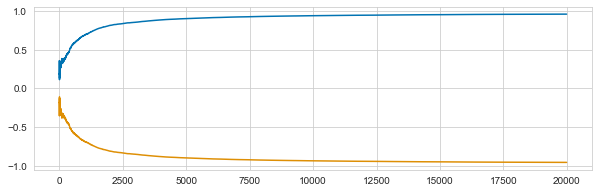

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(avg_reward_history1[10:])
ax.plot(avg_reward_history2[10:])

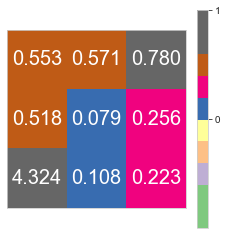

0 [0 0] 0.5525299907459512
1 [0 1] 0.5713150096137157
2 [0 2] 0.780048390509249
3 [1 0] 0.5177493358537654
4 [1 1] 0.0791931014776378
5 [1 2] 0.2561178700878829
6 [2 0] 4.324237055837152
7 [2 1] 0.10764072628247723
8 [2 2] 0.2231503729967711
6


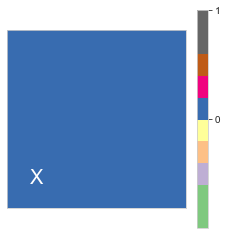

0


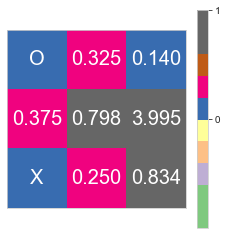

0 [0 1] 0.3251935332005711
1 [0 2] 0.14045808840241347
2 [1 0] 0.3751782179916665
3 [1 1] 0.7981100677484557
4 [1 2] 3.9949348936531317
5 [2 1] 0.24966478495322286
6 [2 2] 0.833832303679217
4


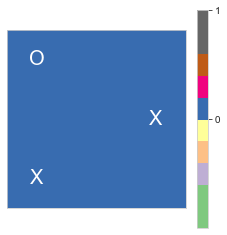

5


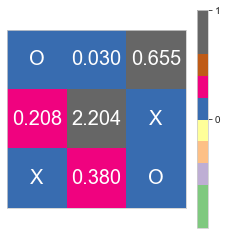

0 [0 1] 0.029746552377494906
1 [0 2] 0.6550775350518337
2 [1 0] 0.20823722814697032
3 [1 1] 2.2037101130301457
4 [2 1] 0.3795217744927043
3


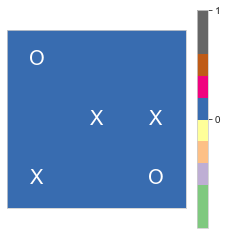

2


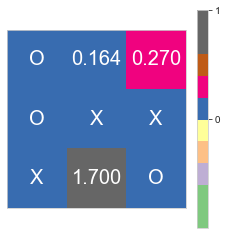

0 [0 1] 0.16431296912496662
1 [0 2] 0.2698575035415355
2 [2 1] 1.6999999999999993
2


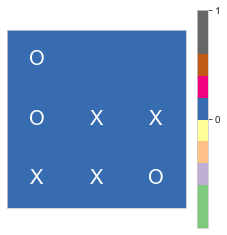

0


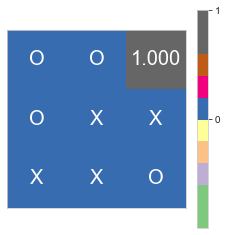

0 [0 2] 1.0
0
Крестики выиграли!


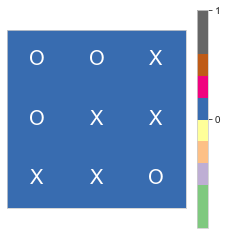

In [18]:
plot_test_game(env, player1, None, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=20)

### 3x3 нолики

In [19]:
player1 = RandomPlayer()
player2 = QPlayer(alpha=0.5, epsilon=0.0, gamma=0.7)
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
avg_reward_history1, avg_reward_history2 = learn(200000, player1, player2, env) 

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [01:19<00:00, 2527.56it/s]


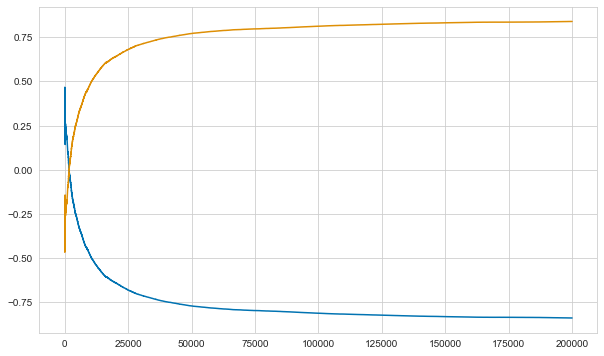

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(avg_reward_history1[10:])
ax.plot(avg_reward_history2[10:])

### Double Q 3x3 крестики 

In [92]:
player1 = DQPlayer(alpha=0.5, epsilon=0.1, gamma=0.9)
player2 = RandomPlayer()
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
avg_reward_history1, avg_reward_history2 = learn(200000, player1, player2, env) 

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [01:44<00:00, 1919.45it/s]


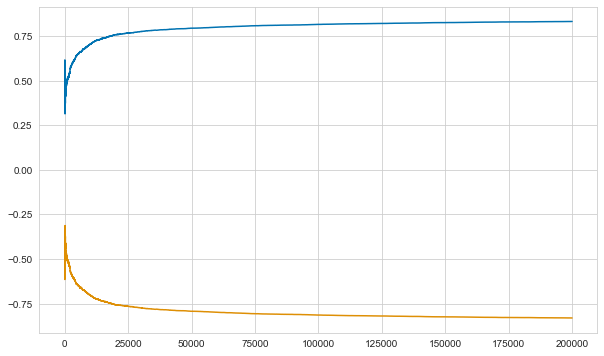

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(avg_reward_history1[10:])
ax.plot(avg_reward_history2[10:])

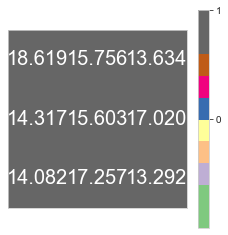

0 [0 0] 18.61942691923395
1 [0 1] 15.755866398522102
2 [0 2] 13.63446878845679
3 [1 0] 14.317422239832371
4 [1 1] 15.602753510483849
5 [1 2] 17.02018338094193
6 [2 0] 14.081772855211806
7 [2 1] 17.256656246063333
8 [2 2] 13.291851059312233
0


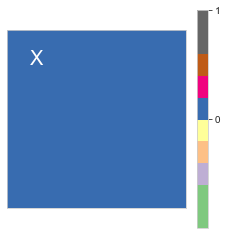

5


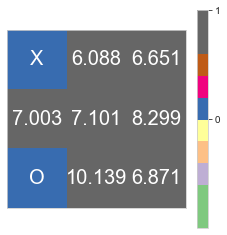

0 [0 1] 6.0877310993164615
1 [0 2] 6.650851455017875
2 [1 0] 7.0033479529034235
3 [1 1] 7.101409764399175
4 [1 2] 8.29884964681867
5 [2 1] 10.138784799078387
6 [2 2] 6.871253173295476
5


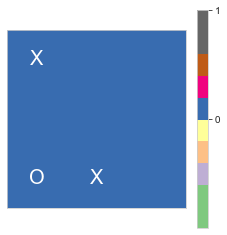

5


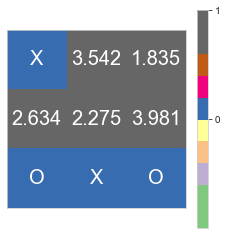

0 [0 1] 3.5417427339308736
1 [0 2] 1.8351790375769848
2 [1 0] 2.6337763169470323
3 [1 1] 2.275050494400287
4 [1 2] 3.980539796899417
4


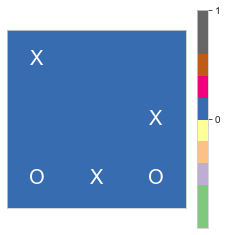

3


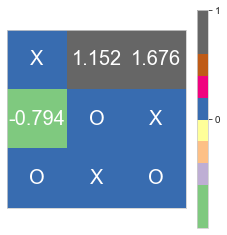

0 [0 1] 1.152483711037375
1 [0 2] 1.6760451780209606
2 [1 0] -0.7935673565992531
1


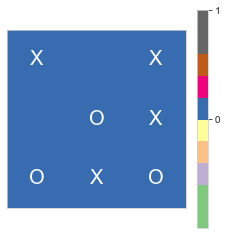

1


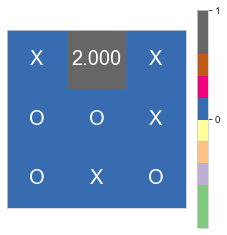

0 [0 1] 2.0
0
Крестики выиграли!


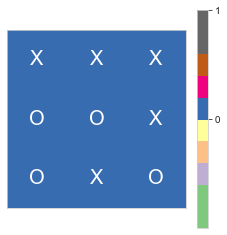

In [94]:
plot_test_game(env, player1, None, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=20)

### 4x4 крестики

In [21]:
total_episodes = 20000000
player1 = QPlayer(alpha=0.5, epsilon=0.0, gamma=0.7)
player2 = RandomPlayer()
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
avg_reward_history1, avg_reward_history2 = learn(20000, player1, player2, env) 

100%|███████████████████████████████████████████████████████████████████| 20000000/20000000 [5:48:59<00:00, 955.13it/s]


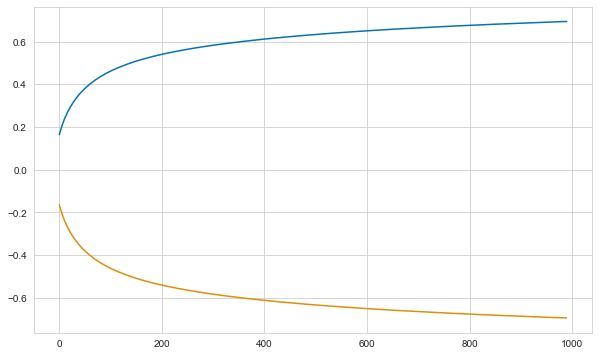

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(avg_reward_history1[10:])
ax.plot(avg_reward_history2[10:])

# Часть 2

In [11]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
class FCNetwork(nn.Module):
    def __init__(self, state_size):
        super(FCNetwork, self).__init__()
        self.l1 = nn.Linear(state_size, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 64)
        self.l5 = nn.Linear(64, state_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        return x


class ConvNetwork(nn.Module):
    def __init__(self, state_size):
        super(ConvNetwork, self).__init__()
        self.size = int(np.sqrt(state_size))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.fl = nn.Flatten()
        self.l1 = nn.Linear(64 * state_size, 256)
        self.l2 = nn.Linear(256, state_size)

    def forward(self, x):
        x = x.view(-1, 1, self.size, self.size)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=5, stride=1)
        x = self.fl(x)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


In [13]:
class PlayerDQN:
    def __init__(self, state_size, net, env, memory, is_first=True, learning_rate=0.01, gamma=0.8, batch_size=64, eps_init=0.9, eps_final=0.01, eps_decay=200):
        self.env = env
        self.model1 = net(state_size)
        self.model2 = net(state_size)
        self.memory = memory
        self.n_actions = state_size
        self.steps_done = 0
        self.episode_durations = []
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.is_first = is_first
        self.eps_init = eps_init
        self.eps_final = eps_final
        self.eps_decay = eps_decay
        self.num_step = 0
        self.optimizer = optim.Adam(self.model1.parameters(), self.learning_rate)

    def select_greedy_action(self, state):
        return self.model1(state).data.max(1)[1].view(1, 1)

    def evaluate(self, total_episodes, render=False):
        rewards = []
        tbar = tqdm.tqdm(range(total_episodes))
        for n in tbar:
            reward = self.eval_episode(render)
            rewards.append(reward)
            win = sum([1 for x in rewards if x ==1])
            lost = sum([1 for x in rewards if x == -1])
            wrong = sum([1 for x in rewards if x == -10])
            tbar.set_description("win {} lost {} wrong {}".format(win, lost, wrong))
        return rewards, win, lost, wrong

    
    def eval_episode(self, render=False):
        self.env.reset()
        state = self.env.getBoardAsArray()

        self.model1.eval()

        if not self.is_first:
            _, reward, _, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            state = self.env.getBoardAsArray()
        done = False
        while not done:
            if render:
                self.env.render()

            state_tensor = torch.tensor([state], dtype=torch.float32)
            actions = self.model1(state_tensor).data
            action = actions.max(1)[1].view(1, 1)            

            _, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
            next_state = self.env.getBoardAsArray()

            if not done:
                _, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                next_state = self.env.getBoardAsArray()
                if render:
                    self.env.render()

            if not self.is_first and abs(reward) == 1:
                reward = -reward
            state = next_state
        
        return reward
    
    def train(self, total_episodes, greedy=False, render=False):
        avg_reward_history = []
        rewards_sum = 0
        rewards = []
        losses = []
        tbar = tqdm.tqdm(range(total_episodes))
        for n in tbar:
            reward = self.run_episode(losses, greedy, render)
            rewards_sum += reward
            avg_reward_history.append(rewards_sum / (n + 1))
            rewards.append(reward)
            win = sum([1 for x in rewards[-100:] if x ==1])
            lost = sum([1 for x in rewards[-100:] if x == -1])
            wrong = sum([1 for x in rewards[-100:] if x == -10])
            tbar.set_description("Avg reward {} win {} lost {} wrong {}".format(sum(rewards[-100:])/100, win, lost, wrong))
        return avg_reward_history

    def run_episode(self, losses, greedy=False, render=False):
        self.env.reset()
        state = self.env.getBoardAsArray()

        if self.num_step % 50 == 0:
            self.model2.load_state_dict(self.model1.state_dict())
        self.model1.eval()
        self.model2.eval()

        if not self.is_first:
            _, reward, _, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            state = self.env.getBoardAsArray()
        done = False
        while not done:
            if render:
                self.env.render()

            self.num_step += 1
            state_tensor = torch.tensor([state], dtype=torch.float32)
            if greedy:
                actions = self.model1(state_tensor).data
                action = actions.max(1)[1].view(1, 1)
            else:
                sample = random.random()
                eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(
                    -1. * self.num_step / self.eps_decay)
                if sample > eps_threshold:
                    actions = self.model1(state_tensor).data
                    action = actions.max(1)[1].view(1, 1)
                else:
                    actions = self.model1(state_tensor).data
                    action = torch.tensor([[random.randrange(self.n_actions)]], dtype=torch.int64)

            _, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
            next_state = self.env.getBoardAsArray()

            if not done:
                _, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                next_state = self.env.getBoardAsArray()

            if not self.is_first and abs(reward) == 1:
                reward = -reward

            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            if done:
                expected = reward
            else:
                next_actions1 = self.model1(next_state_tensor).data
                next_actions2 = self.model2(next_state_tensor).data
                next_action = next_actions1.data.max(1)[1].numpy()[0]
                expected = reward + self.gamma * next_actions2[0][next_action].numpy()

            transition = (state_tensor, action, torch.tensor([expected], dtype=torch.float32), abs(actions[0][int(action[0][0])].numpy() - expected))
            self.memory.store(transition)

            state = next_state

        if len(self.memory) > self.batch_size:
            for _ in range(int(len(self.memory)/self.batch_size)):
                loss = self.learn()
                losses.append(loss)
            self.model1.eval()

        return reward

    def learn(self):
        self.model1.train()
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_expected, _ = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_expected = Variable(torch.cat(batch_expected))

        Q = self.model1(batch_state).gather(1, batch_action).reshape([self.batch_size])

        loss = F.smooth_l1_loss(Q, batch_expected)
        # loss = F.mse_loss(Q, batch_expected)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.data.numpy()

    def save(self, filename):
        torch.save(self.model1, filename)
        
    def load(self, filename):
        self.model1 = torch.load(filename)
        self.model2.load_state_dict(self.model1.state_dict())

### DQN 3x3 крестики

In [19]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
memory = ReplayMemory(10000)
player = PlayerDQN(9, ConvNetwork, env, memory, learning_rate=0.001, gamma=0.8, batch_size=128, eps_init=0.9, eps_final=0.0, eps_decay=400)
player.train(2000)
player.save('conv3_model_1000')

Avg reward 0.86 win 93 lost 7 wrong 0: 100%|███████████████████████████████████████| 2000/2000 [32:45<00:00,  1.02it/s]


In [20]:
player = PlayerDQN(9, ConvNetwork, env, memory)
player.load('conv3_model_1000')

In [21]:
result = player.evaluate(1000)

win 951 lost 46 wrong 0: 100%|████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.54it/s]


In [22]:
memory = ReplayMemory(10000)
player0 = PlayerDQN(9, ConvNetwork, env, memory, is_first=False, learning_rate=0.001, gamma=0.8, batch_size=128, eps_init=0.9, eps_final=0.0, eps_decay=400)
player0.train(2000)
player0.save('conv3_model_0_2000')

Avg reward 0.17 win 59 lost 32 wrong 1: 100%|██████████████████████████████████████| 2000/2000 [26:33<00:00,  1.26it/s]


In [25]:
player00 = PlayerDQN(9, ConvNetwork, env, memory)
player00.load('conv3_model_0_2000')

In [26]:
result = player00.evaluate(1000)

win 437 lost 179 wrong 319: 100%|██████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.18it/s]


# Часть 3

In [12]:
class MCTSPlayer:

    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, n_rollouts=50, player=1, c=1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.n_rollouts = n_rollouts
        self.player = player
        self.state_nodes = {}
        self.id_nodes = {}
        self.ids = 0
        self.c = c

    def get_action(self, state, actions):
        if state in self.state_nodes:
            node = self.state_nodes[state]
        else:
            node = {'id': self.ids,
                    'a': None,
                    'w': 0,
                    'n': 0,
                    'pn': None,
                    's': state,
                    'c': [],
                    'p': self.player}
            self.ids += 1
            self.state_nodes[state] = node
            self.id_nodes[node['id']] = node
        self.mcts(node)
        best_node = node['c'][0]
        for cn in node['c']:
            if cn['w']/(cn['n'] + 1e-4) < best_node['w']/(best_node['n'] + 1e-4):
                best_node = cn
        for i, a in enumerate(actions):
            if a[0] == best_node['a'][0] and a[1] == best_node['a'][1] :
                return i

    def mcts(self, r_node):
        for i in range(self.n_rollouts):
            leaf = self.selection(r_node)
            cnode = self.expansion(leaf)
            winner = self.simulation(cnode)
            self.backpropagation(cnode, winner)

    def backpropagation(self, node, winner):
        while node is not None:
            node['n'] += 1
            if winner == node['p']:
                node['w'] += 1
            node = node['pn']

    def simulation(self, node):
        board = self.state_to_board(node['s'])
        cur_turn = node['p']
        while True:
            winner = self.is_terminal_state(board, -cur_turn)
            if winner is not None:
                return winner
            a = random.choice(self.get_empty_spaces(board))
            board[a[0]][a[1]] = cur_turn
            cur_turn = -cur_turn

    def selection(self, node):
        while len(node['c']) > 0:
            max_v = node['c'][0]['w']/(node['c'][0]['n'] + 1e-4) + self.c * np.sqrt(np.log(node['n'])/(node['c'][0]['n'] + 1e-4))
            max_node = node['c'][0]
            for cn in node['c']:
                v = cn['w'] / (cn['n'] + 1e-4) + self.c * np.sqrt(np.log(node['n']) / (cn['n'] + 1e-4))
                if max_v < v:
                    max_node = cn
                    max_v = v
            node = max_node
        return node

    def expansion(self, node):
        winner = self.is_terminal_node(node)
        if winner is None :
            for a in self.get_empty_spaces(self.state_to_board(node['s'])):
                nstate = self.apply_action(node['s'], a, node['p'])
                cnode = {'id': self.ids,
                         'a': a,
                         'w': 0,
                         'n': 0,
                         'pn': node,
                         's': nstate,
                         'c': [],
                         'p': -node['p']}
                self.ids += 1
                self.state_nodes[nstate] = cnode
                self.id_nodes[node['id']] = cnode
                node['c'].append(cnode)
            node = random.choice(node['c'])
        return node

    def apply_action(self, state, action, player):
        board = self.state_to_board(state)
        board[action[0]][action[1]] = player
        return ''.join(['%s' % (x + 1) for x in board.reshape(self.n_rows * self.n_cols)])

    def state_to_board(self, state):
        return np.array([int(x) - 1 for x in state]).reshape([self.n_rows, self.n_cols])

    def is_terminal_node(self, node):
        return self.is_terminal_state(self.state_to_board(node['s']), -node['p'])

    def is_terminal_state(self, board, cur_turn):
        cur_marks, cur_p = np.where(board == cur_turn), cur_turn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                return cur_turn

        if len(self.get_empty_spaces(board)) == 0:
            return 0

        return None

    def get_empty_spaces(self, board):
        res = np.where(board == 0)
        return np.array([(i, j) for i, j in zip(res[0], res[1])])


def run_episode(env, player1, player2):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            action_idx = player1.get_action(s, actions)
        else:
            action_idx = player2.get_action(s, actions)
        _, reward, done, _ = env.step(actions[action_idx])
    return reward


In [14]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
rewards = []
for i in range(100):
    player1 = MCTSPlayer()
    player2 = RandomPlayer()
    rewards.append(run_episode(env, player1, player2))
print("Win", sum([1 for x in rewards if x == 1]))
print("Loss", sum([1 for x in rewards if x == -1]))
print("Draw", sum([1 for x in rewards if x == 0]))

Win 80
Loss 3
Draw 17
